In [2]:
import os
import numpy as np
import pandas as pd
import csv

from matplotlib import pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from tqdm import tqdm
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import KFold, train_test_split

import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# <span style="font-size:20pt">A bit of theory from seismic exploration</span>

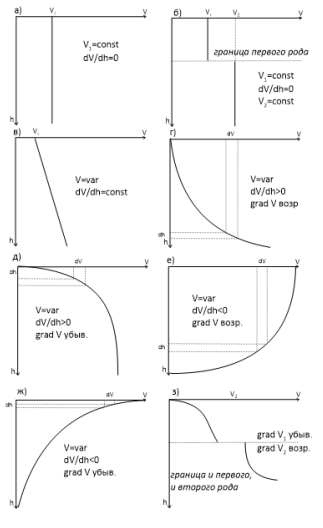

In [3]:
Image("/kaggle/input/seismic-images-theory/Print_1.png")

1.1. The simplest models of media used in seismic exploration for
the dependence of velocity and depth V(h):
- a) is a homogeneous half–space with constant velocity;
- b) – horizontally layered medium (SCS);
- c) - vertically heterogeneous medium with variable velocity and constant
velocity gradient;
- d) is a vertically inhomogeneous medium with variable velocity and a positive
increasing velocity gradient;
- e) is a vertically inhomogeneous medium with variable velocity and a positive
decreasing velocity gradient.
- f) is a vertically inhomogeneous medium with variable velocity and negative
an increasing gradient;

We work with 3 types of models (it's easy to guess which ones)

**Types of seismic exploration**

According to the location, there are: onshore, offshore, underground and borehole
seismic surveys (VSP). According to the purpose and tasks to be solved, the following are distinguished:

• shallow seismic exploration:
- when studying the geological structure of the upper part
of the section;
- in construction to determine the elastic modules of rocks;
- when karsts and suffusion hazards are detected;
- when determining the groundwater level;
- when studying the properties of loose sediments on the shelf;
- when searching for gas hydrates.

• Oil and gas seismic exploration:
- in the search and exploration of hydrocarbons;
- when determining and adjusting the locations of production wells;
- when determining porosity and oil saturation parameters;
- during monitoring of developed fields.

• Structural seismic exploration:
- when studying the deep structure of the Earth;
- when mapping the foundation;
- when mapping regional faults



**Types of seismic velocities used in seismic exploration**

The true velocity of a seismic wave is the velocity in an infinitesimally small volume of a medium, i.e., where its heterogeneity is least affected. The average seismic velocity is defined as the ratio of the sum of the layer capacities to the sum of the wave travel times in each layer.:

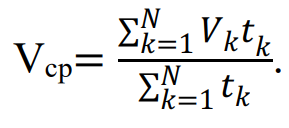

In [4]:
Image("/kaggle/input/seismic-images-theory/Print_2.png")

The interval velocity is the velocity at a certain depth range.:

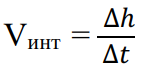

In [5]:
Image("/kaggle/input/seismic-images-theory/Print_3.png")

The reservoir velocity is rigidly tied to a certain layer:

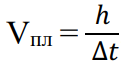

In [6]:
Image("/kaggle/input/seismic-images-theory/Print_4.png")

Another type of velocity is apparent velocity. This is what we determine when working on land or offshore on the observation line. The apparent speed can be calculated using the formula: 

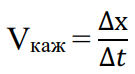

In [7]:
Image("/kaggle/input/seismic-images-theory/Print_5.png")

where dx is the distance between the receivers. The apparent velocity, depending on the angle of approach of the beam to the surface, obeys Bendorf's law:

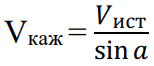

In [8]:
Image("/kaggle/input/seismic-images-theory/Print_6.png")

where a is the angle between the ray and the surface normal. It follows from this relation that the apparent velocity varies from the value of the true velocity to infinity.

In seismic exploration, we can plot the dependence of the arrival time of a wave on the coordinate of the geophone registering this wave. Such a graph will be called the hodograph of a particular wave. The apparent speed can be easily determined by its hodograph using the first formula.

**Seismic waves and their kinematic characteristics**

The seismogram and its elements. By placing the reception points on the profile, we can record the arrival time of the seismic wave.

Hodograph is the dependence of the time of arrival of a seismic wave on the coordinates of the receiving (removal) points. Having built a hodograph, we can proceed to calculating velocities using mathematical equations, which we will discuss later. If we place a geophone at some point that will register ground fluctuations, then at the output we will get a field record - a seismic trace.

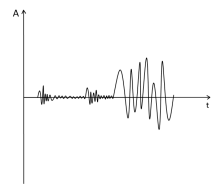

In [9]:
Image("/kaggle/input/seismic-images-theory/Print_7.png")

The seismic path is the dependence of the amplitude (In or mV) of seismic events on the time of their registration (s or ms). The fastest way to reach the seismic receiver is a longitudinal wave, the first entry of which is clearly visible on the seismic path (a sharp deviation from zero of the soil particles). After a while, the longitudinal wave will fade out and the next one will arrive – the transverse wave. Next comes a huge amplitude of surface waves, which are characterized by high amplitude, low frequency and low speed. Such
The seismic event reflected on the graph is a seismic track or seismic path. Obviously, each reception point will record its own seismic path. The pulse amplitudes will be determined by the reflection coefficients.

In real seismic exploration, not one reception point is used, but many. By placing a certain number of geophones and activating the signal, we will get our own seismic path for each geophone. The totality (ensemble) The seismic traces obtained for a single excitation point are called a seismogram. The seismogram shows the numbers of reception points along the abscissa axis, usually in the same step, and the recording time, which is set by a human, on the other axis.

We only work with direct and reflected waves, I'll tell you more about them.

A straight wave can be detected if we consider the first layer from the surface to be homogeneous. Let's say we have a source and receivers that register our signal. A straight line will be a wave propagating along the surface of the earth at a certain speed. The hodograph of this wave will be a straight line. If the task is to determine the travel time of the signal to the receiver with a certain coordinate, then the dependence will have the form:

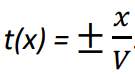

In [10]:
Image("/kaggle/input/seismic-images-theory/Print_8.png")

By specifying the distance explicitly, we get the time value at each point. 

So, the hodograph of a straight wave has the form of a linear function. A plus sign is placed when we go to the right of the source, a minus sign is placed to the left. In space, the hodograph of a straight wave will be a cone. The higher the velocity in the medium, the more the hodograph is pressed against the Oh axis. The longitudinal wave hodograph will always be more pressed against the axis than the transverse wave hodograph, due to the difference in speeds for them. The apparent speed in this case is equal to the true speed. The front of a straight wave is a cylinder.

The reflected wave has a complex hodograph equation (a parabola with branches up), I will not give it. A reflected wave is a wave that has reflected from the layer only 1 time (more than 1 time is a multiple reflected). Consider their hodographs (direct and reflected waves):

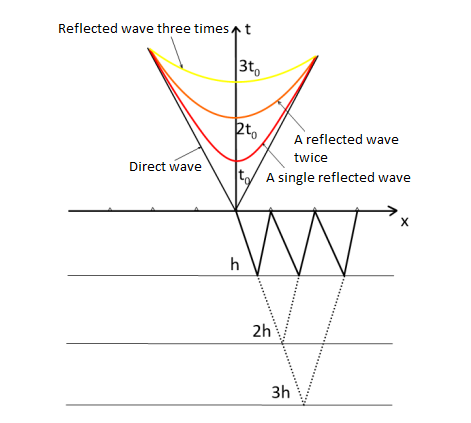

In [11]:
Image("/kaggle/input/seismic-images-theory/Print_9.png")

# <span style="font-size:20pt">Stage 1: Exploratory Data Analysis (EDA)</span>

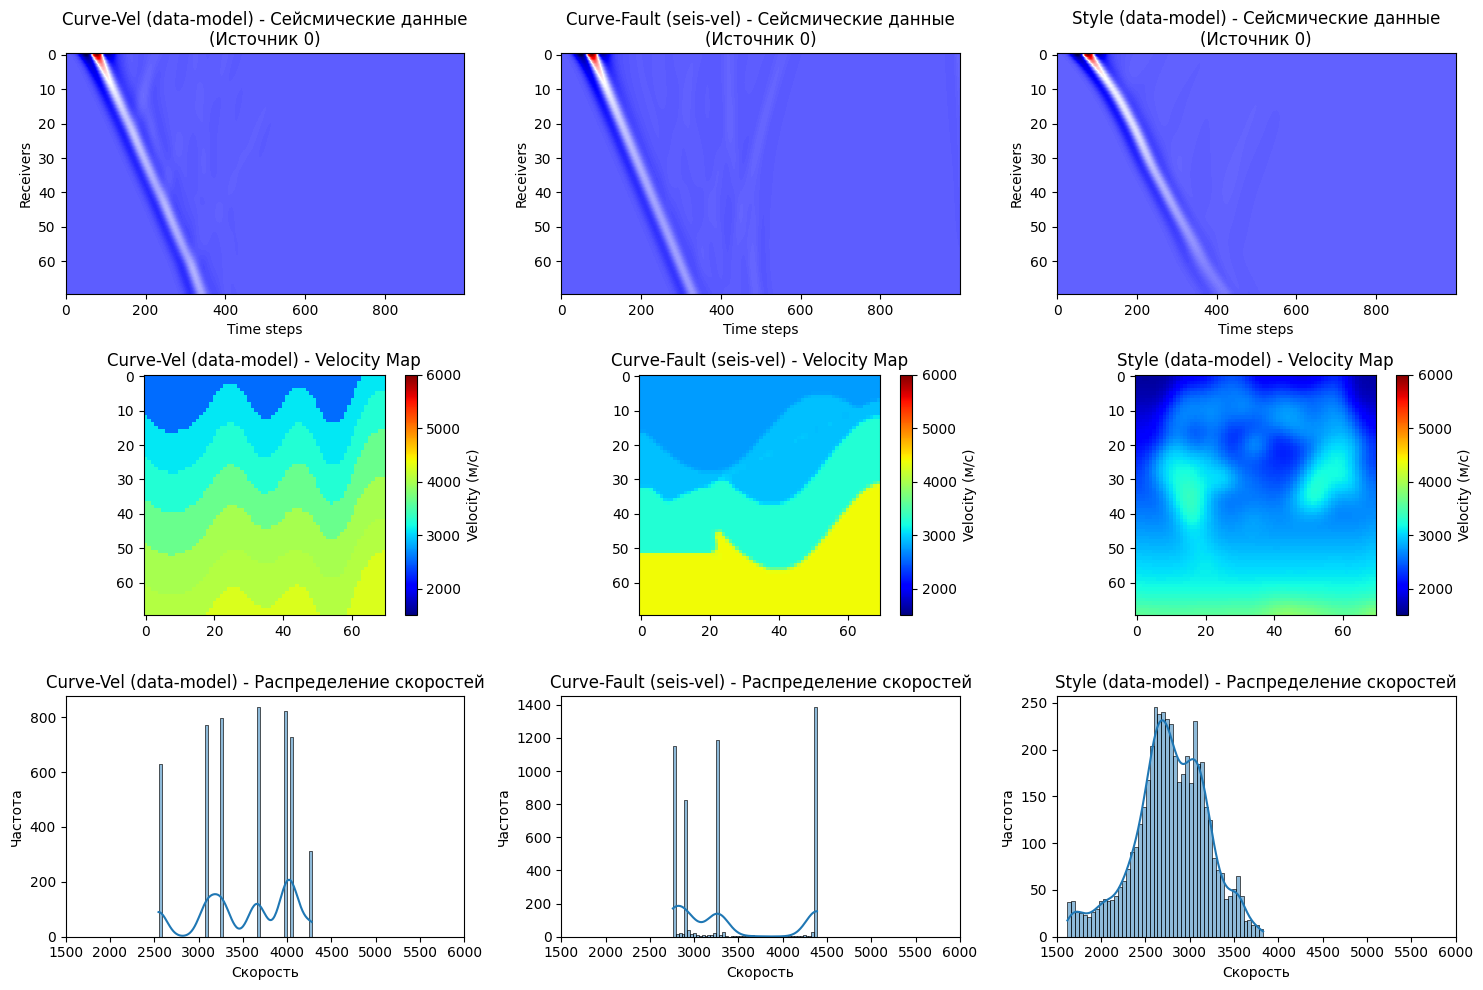

In [12]:
def perform_eda(data_path):
    example_files = {
        'Curve-Vel (data-model)': {'seismic': '/kaggle/input/waveform-inversion/train_samples/CurveVel_A/data/data2.npy', 'velocity': '/kaggle/input/waveform-inversion/train_samples/CurveVel_A/model/model2.npy'},
        'Curve-Fault (seis-vel)': {'seismic': '/kaggle/input/waveform-inversion/train_samples/CurveFault_A/seis4_1_0.npy', 'velocity': '/kaggle/input/waveform-inversion/train_samples/CurveFault_A/vel4_1_0.npy'},
        'Style (data-model)': {'seismic': '/kaggle/input/waveform-inversion/train_samples/Style_A/data/data2.npy','velocity': '/kaggle/input/waveform-inversion/train_samples/Style_A/model/model2.npy'}}
    
    plt.figure(figsize=(15, 10))
    for i, (family, files) in enumerate(example_files.items(), 1):
        # Uploading data with the correct path
        seis_data = np.load(data_path / files['seismic'], mmap_mode='r')[0]
        vel_map = np.load(data_path / files['velocity'], mmap_mode='r')[0]
        
        # Correcting the velocity map shape
        if vel_map.ndim == 3:  # If the dimension is (1, H, W)
            vel_map = vel_map.squeeze(0)  # We delete the first dimension
        
        # Graph 1: Slices of seismic data
        plt.subplot(3, 3, i)
        plt.imshow(seis_data[0].T, aspect='auto', cmap='seismic')  # Simplified access to data
        plt.title(f'{family} - Сейсмические данные\n(Источник 0)')
        plt.xlabel('Time steps')
        plt.ylabel('Receivers')
        
        # График 2: Velocity Map
        plt.subplot(3, 3, i+3)
        plt.imshow(vel_map, cmap='jet', vmin=1500, vmax=6000)  # Added a range of speeds
        plt.title(f'{family} - Velocity Map')
        plt.colorbar(label='Velocity (м/с)')
        
        # Graph 3: Velocity distribution
        plt.subplot(3, 3, i+6)
        sns.histplot(vel_map.ravel(), bins=50, kde=True)
        plt.title(f'{family} - Распределение скоростей')
        plt.xlabel('Скорость')
        plt.ylabel('Частота')
        plt.xlim(1500, 6000)  # Range limitation
    
    plt.tight_layout()
    plt.show()

data_path = Path('/kaggle/input/waveform-inversion/train_samples')
perform_eda(data_path)

In [13]:
def perform_advanced_eda(data_path):
    # Analyze different data families with proper relative file structure
    families = {
        'FlatVel': {
            'path': 'FlatVel_{version}/data/data*.npy',
            'velocity': 'FlatVel_{version}/model/model*.npy'
        },
        'CurveVel': {
            'path': 'CurveVel_{version}/data/data*.npy',
            'velocity': 'CurveVel_{version}/model/model*.npy'
        },
        'Style': {
            'path': 'Style_{version}/data/data*.npy',
            'velocity': 'Style_{version}/model/model*.npy'
        },
        'FlatFault': {
            'path': 'FlatFault_{version}/seis*.npy',
            'velocity': 'FlatFault_{version}/vel*.npy'
        },
        'CurveFault': {
            'path': 'CurveFault_{version}/seis*.npy',
            'velocity': 'CurveFault_{version}/vel*.npy'
        }
    }

    # Create sample comparison across families
    compare_families = [('FlatVel', 'A'),
                        ('CurveVel', 'A'),
                        ('Style', 'A'),
                        ('CurveFault', 'A')]
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[f"{name}_{ver}" for name, ver in compare_families],
        specs=[[{'type': 'heatmap'}, {'type': 'heatmap'}],
               [{'type': 'heatmap'}, {'type': 'heatmap'}]]
    )
    
    for i, (family, version) in enumerate(compare_families):
        try:
            # Generate relative path patterns
            seis_pattern = families[family]['path'].format(version=version)
            vel_pattern = families[family]['velocity'].format(version=version)
            
            # Find files relative to data_path
            seis_files = sorted(data_path.glob(seis_pattern))
            vel_files = sorted(data_path.glob(vel_pattern))
            
            if not seis_files or not vel_files:
                print(f"Missing files for {family}_{version}")
                continue

            # Load sample data using first matching file
            seis_data = np.load(seis_files[0], mmap_mode='r')[0]
            vel_map = np.load(vel_files[0], mmap_mode='r')[0].squeeze()

            row = i//2 + 1
            col = i%2 + 1
            
            # Add visualizations
            #fig.add_trace(go.Heatmap(z=seis_data[0,:,:].T, colorscale='Viridis'), row=row, col=col)
            fig.add_trace(go.Heatmap(z=vel_map, colorscale='Jet', showscale=False),row=row, col=col)

        except Exception as e:
            print(f"Error processing {family}_{version}: {str(e)}")
            continue
    
    fig.update_layout(title_text='Cross-Family Data Comparison', height=1000, width=1400)
    #fig.show(renderer='iframe')
    py.iplot(fig)

# Execute EDA with corrected paths
init_notebook_mode(connected=True)
perform_advanced_eda(Path('/kaggle/input/waveform-inversion/train_samples'))

# <span style="font-size:20pt">Stage 2: Configuration and data preparation</span>

In [14]:
class Config:
    output_shape = (70, 70)

In [15]:
def load_data(data_path):
    # Uploading data (seis/data)
    # data_path = '/kaggle/input/waveform-inversion/train_samples'
    # Uploading paths to data files
    all_inputs = [f for f in Path(data_path).rglob('*.npy') if ('seis' in f.stem) or ('data' in f.stem)]
    
    def get_output_files(input_files):
        # Generating paths to target files
        return [Path(str(f).replace('seis', 'vel').replace('data', 'model')) for f in input_files]
    
    all_outputs = get_output_files(all_inputs)
    assert all(f.exists() for f in all_outputs)
    return all_inputs, all_outputs

# <span style="font-size:20pt">Stage 3: Defining the dataset and model</span>

In [16]:
class SeismicDataset(Dataset):
    def __init__(self, input_files, output_files, n_examples = 500, augment = True):
        
        self.input_files = input_files    # List of input files
        self.output_files = output_files  # List of files with target data
        self.n_examples = n_examples      # Number of examples in each file
        self.augment = augment            # The augmentation flag
        
        # Calculation of statistics for normalization
        sample = np.load(input_files[0], mmap_mode='r')[0]
        self.input_mean = sample.mean()   # The average value of the input data
        self.input_std = sample.std()     # Standard deviation of the input data
        
        sample = np.load(output_files[0], mmap_mode='r')[0]
        self.output_mean = sample.mean()  # The average value of the target data
        self.output_std = sample.std()    # The standard deviation of the target data


    def __len__(self):
        # Total number of examples
        return len(self.input_files) * self.n_examples

    def __getitem__(self, idx):
        
        # Getting one example of data
        file_idx = idx // self.n_examples  # File index
        sample_idx = idx % self.n_examples # The index of the example in the file
        
        # Loading data from memory mapping
        X = np.load(self.input_files[file_idx], mmap_mode='r')[sample_idx]  # Uploading seismic data
        y = np.load(self.output_files[file_idx], mmap_mode='r')[sample_idx] # Loading the velocity map
        
        # Normalization of data
        X = (X - self.input_mean) / self.input_std  # Normalization of input data
        y = (y - self.output_mean) / self.output_std # Normalization of target data
        
        # Augmentation: horizontal reflection
        if self.augment and np.random.rand() > 0.5:
            X = np.flip(X, axis=-1).copy()  # Reflection on the last axis
            y = np.flip(y, axis=-1).copy()
        
        # Conversion to PyTorch tensors
        X = torch.FloatTensor(X).mean(dim=0, keepdim=True) # Averaging by sources
        y = torch.FloatTensor(y)                           # Target Data Conversion
        
        return X, y

# <span style="font-size:20pt">Stage 4: U-Net Model Architecture</span>

In [17]:
class SeismicUNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder blocks with downsampling
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),  # Initial feature extraction
            nn.BatchNorm2d(64),               # Batch normalization
            nn.ReLU(),                        # Non-linear activation
            nn.Conv2d(64, 64, 3, padding=1),  # Feature refinement
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)                   # Spatial downsampling
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), # Deeper feature extraction
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Bottleneck with expanded features
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),  # High-level features
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, stride=2)  # Upsampling
        )
        
        # Decoder blocks with skip connections
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),  # Combine features
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2)
        )
        
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),  # Final feature combination
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)                # Output channel reduction
        )
        
        # Final size adjustment
        self.final_adjust = nn.Sequential(
            nn.Upsample(size=Config.output_shape, mode='bilinear'),  # Ensure output size
            nn.Conv2d(1, 1, 1)                                       # Final adjustment
        )
    
    def forward(self, x):
        # Forward pass through the network
        
        # Encoder path
        e1 = self.enc1(x)  # First encoding stage
        e2 = self.enc2(e1)  # Second encoding stage
        
        # Bottleneck processing
        bn = self.bottleneck(e2)  # Process features at lowest resolution
        
        # Decoder path with skip connections
        d2 = self.dec2(torch.cat([bn, F.interpolate(e2, bn.shape[2:], mode='bilinear')], 1))
        d1 = self.dec1(torch.cat([d2, F.interpolate(e1, d2.shape[2:], mode='bilinear')], 1))
        
        # Final output adjustment
        return self.final_adjust(d1)

In [18]:
class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mae = nn.L1Loss()
        self.mse = nn.MSELoss()
    
    def gradient_loss(self, pred, target):
        # Adding a dimension check
        if pred.dim() == 3:
            pred = pred.unsqueeze(1)  # Add the channel if it is missing
        if target.dim() == 3:
            target = target.unsqueeze(1)
            
        # Size alignment
        if pred.size()[-2:] != target.size()[-2:]:
            pred = F.interpolate(pred, size=target.size()[-2:], mode = 'bilinear')
        
        # Calculation of gradients with correct indexes
        dy_pred = pred[:, :, 1:, :] - pred[:, :, :-1, :]
        dx_pred = pred[:, :, :, 1:] - pred[:, :, :, :-1]
        
        dy_target = target[:, :, 1:, :] - target[:, :, :-1, :]
        dx_target = target[:, :, :, 1:] - target[:, :, :, :-1]
        
        return self.mae(dy_pred, dy_target) + self.mae(dx_pred, dx_target)
    
    def forward(self, pred, target):
        # Reduction to the same dimension
        if pred.dim() != target.dim():
            if pred.dim() == 4:
                pred = pred.squeeze(1)
            else:
                pred = pred.unsqueeze(1)
        
        return (self.mae(pred, target) + 0.3 * self.mse(pred, target) + 0.2 * self.gradient_loss(pred, target))

In [19]:
class Config:
    batch_size = 32
    lr = 1e-4
    epochs = 50
    early_stop = 10             # Early-Stop
    num_workers = 4             # Optional parameter (calculated on GPU)
    input_shape = (5, 1000, 70) # [sources, time_steps, receivers]
    output_shape = (70, 70)     # velocity map
    plot_every = 5

# <span style="font-size:20pt">Stage 5: Training Configuration and Execution</span>

In [20]:
# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')                   # Hardware selection
model = SeismicUNet().to(device)                                                        # Model instantiation
optimizer = torch.optim.AdamW(model.parameters(), lr = Config.lr, weight_decay = 5e-5)  # Optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3)  # LR scheduler
criterion = CombinedLoss()                                                              # Custom loss function
#criterion = nn.L1Loss()                                                                  # None-Custom loss function

In [ ]:
# Uploading data
data_path = '/kaggle/input/waveform-inversion/train_samples'
all_inputs, all_outputs = load_data(data_path)

# Initializing lists to store loss history
train_history = []
val_history = []

# Creating a shared dataset
full_dataset = SeismicDataset(all_inputs, all_outputs)
input_mean = full_dataset.input_mean
input_std = full_dataset.input_std

# Creating a tensor from all the targets
all_targets = torch.stack([torch.FloatTensor(np.load(f)) for f in all_outputs])
output_mean = all_targets.mean().item()
output_std = all_targets.std().item()


# Dividing the data into training and validation ones
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# Applying augmentation to a training dataset
# If the augmentation is controlled by a flag, create new datasets with the necessary parameters
train_ds.dataset.augment = True  # Let's assume that it is possible to change the parameter
val_ds.dataset.augment = False   # Disabling augmentation for validation

# Creating loaders
train_loader = DataLoader(train_ds, batch_size = Config.batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = Config.batch_size, shuffle = False)

best_loss = float('inf')
counter = 0


# The learning cycle
for epoch in range(Config.epochs):
    
    model.train()
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    for X, y in tqdm(train_loader, desc = f'Epoch {epoch+1} [Train]'):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * X.size(0)
    
    model.eval()
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc = f'Epoch {epoch+1} [Val]'):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            epoch_val_loss += loss.item() * X.size(0)
    
    train_loss = epoch_train_loss / len(train_loader.dataset)
    val_loss = epoch_val_loss / len(val_loader.dataset)
    
    # Saving history and logging remain unchanged
    train_history.append(train_loss)
    val_history.append(val_loss)

    scheduler.step(val_loss)
    
    if (epoch+1) % Config.plot_every == 0:
        plt.figure(figsize=(10, 5))
        plt.plot(train_history, label='Train Loss')
        plt.plot(val_history, label='Validation Loss')
        plt.title('Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    print(f'Epoch {epoch+1}/{Config.epochs}')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_2.pth')
        counter = 0
    else:
        counter += 1
        if counter >= Config.early_stop:
            print('Early stopping triggered')
            break

# Final visualization
plt.figure(figsize=(12, 6))
plt.plot(train_history, 'o-', label='Train Loss')
plt.plot(val_history, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.close()

# <span style="font-size:20pt">Stage 6: Prediction and Submission Generation</span>

In [ ]:
class TestDataset(Dataset):
    # Dataset for loading and processing test data
    def __init__(self, files):
        self.files = files  # List of test files
        # Use training statistics for normalization
        self.input_mean = input_mean
        self.input_std = input_std

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load and process test sample
        data = np.load(self.files[idx], mmap_mode = 'r')
        data = (data - self.input_mean) / self.input_std  # Normalize
        data = torch.FloatTensor(data.mean(axis=0, keepdims=True))  # Average sources
        return data, self.files[idx].stem

In [ ]:
# Load best model and predict
test_files = list(Path('/kaggle/input/waveform-inversion/test').glob('*.npy'))
test_ds = TestDataset(test_files)
test_loader = DataLoader(test_ds, batch_size = Config.batch_size)
#model.load_state_dict(torch.load('/kaggle/input/cnn-model-2/best_model_2.pth'))
#model.eval()

In [ ]:
# Generate submission file
x_cols = [f'x_{i}' for i in range(1, 70, 2)]
fieldnames = ['oid_ypos'] + x_cols
with open('submission.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    writer.writeheader()
    with torch.no_grad():
        for X, oids in tqdm(test_loader, desc = 'Predicting'):
            X = X.to(device)
            outputs = model(X).squeeze(1).cpu().numpy()
            # Denormalize predictions
            outputs = outputs * output_std + output_mean
            # Format predictions to submission specs
            for oid, pred in zip(oids, outputs):
                for y_pos in range(Config.output_shape[0]):
                    row = {'oid_ypos': f'{oid}_y_{y_pos}'}
                    # Select odd-indexed columns
                    row.update({f'x_{x}': pred[y_pos, x] for i, x in enumerate(range(1, Config.output_shape[1], 2))})
                    writer.writerow(row)